# Tiny ML on Arduino

## Gesture recognition tutorial

* Credits to Sandeep Mistry - Arduino and Don Coleman - Chariot Solutions

 
https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

# Plot the data

We'll graph the input files on two separate graphs, acceleration and gyroscope, as each data set has different units and scale.

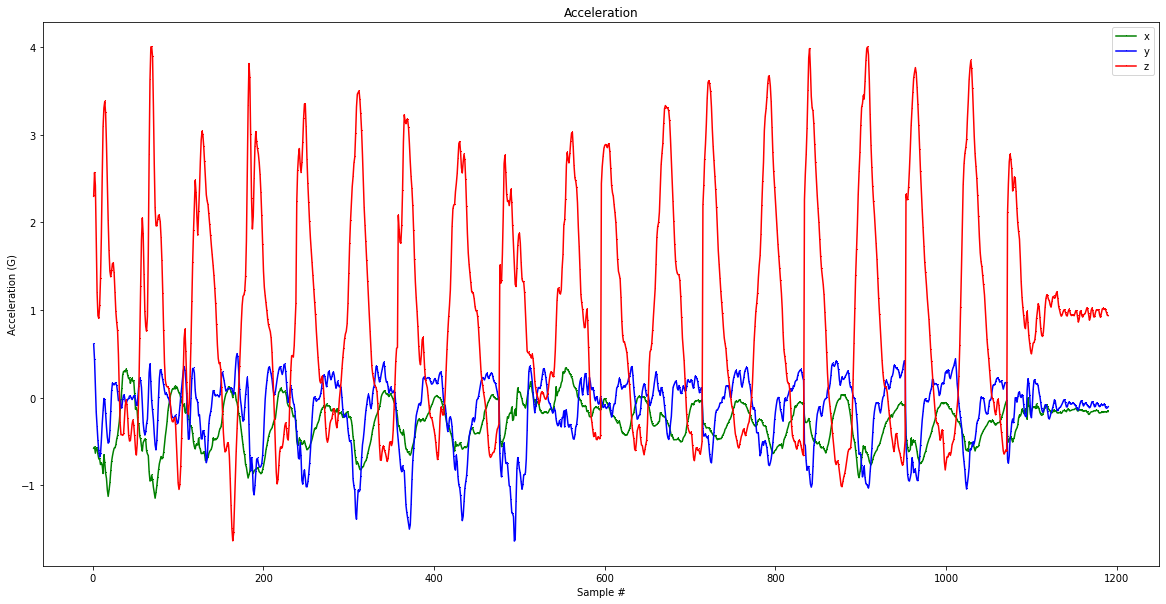

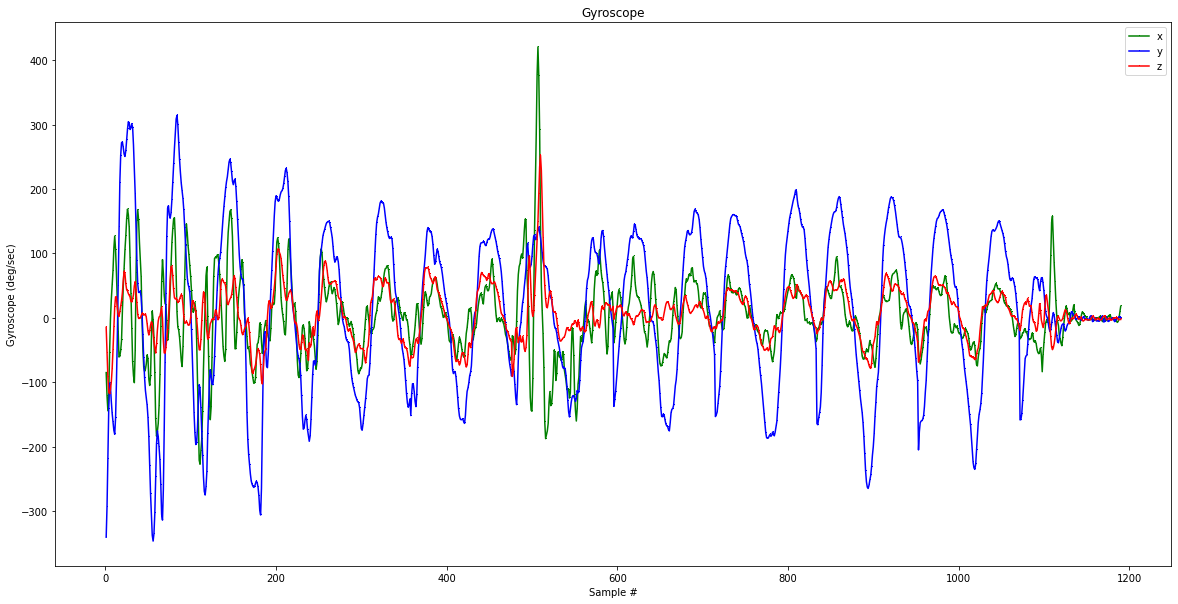

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "./data/tinyml/up.csv"

df = pd.read_csv(filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()


# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "up",
    "side",
]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("./data/tinyml/" + gesture + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

Processing index 0 for gesture 'up'.
	There are 10 recordings of the up gesture.
Processing index 1 for gesture 'side'.
	There are 11 recordings of the side gesture.
Data set parsing and preparation complete.


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [5]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [6]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=200, batch_size=1, validation_data=(inputs_validate, outputs_validate))

model.save("model")

Epoch 1/200
12/12 [==============================] - 1s 14ms/step - loss: 0.2958 - mae: 0.5339 - val_loss: 0.2422 - val_mae: 0.4903
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 0.2572 - mae: 0.5044 - val_loss: 0.2455 - val_mae: 0.4950
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 0.2504 - mae: 0.4854 - val_loss: 0.2463 - val_mae: 0.4960
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.2532 - mae: 0.5030 - val_loss: 0.2437 - val_mae: 0.4928
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.2564 - mae: 0.5052 - val_loss: 0.2466 - val_mae: 0.4962
Epoch 6/200
12/12 [==============================] - 0s 8ms/step - loss: 0.2520 - mae: 0.5019 - val_loss: 0.2464 - val_mae: 0.4960
Epoch 7/200
12/12 [==============================] - 0s 10ms/step - loss: 0.2552 - mae: 0.5048 - val_loss: 0.2447 - val_mae: 0.4940
Epoch 8/200
12/12 [==============================] - 0s 9ms/step - loss: 0.2531 -

Epoch 63/200
12/12 [==============================] - 0s 14ms/step - loss: 0.1481 - mae: 0.3732 - val_loss: 0.1384 - val_mae: 0.3500
Epoch 64/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1421 - mae: 0.3672 - val_loss: 0.1354 - val_mae: 0.3382
Epoch 65/200
12/12 [==============================] - 0s 5ms/step - loss: 0.1352 - mae: 0.3578 - val_loss: 0.1345 - val_mae: 0.3319
Epoch 66/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1240 - mae: 0.3291 - val_loss: 0.1696 - val_mae: 0.3947
Epoch 67/200
12/12 [==============================] - 0s 5ms/step - loss: 0.1220 - mae: 0.3311 - val_loss: 0.1606 - val_mae: 0.3779
Epoch 68/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1351 - mae: 0.3490 - val_loss: 0.1435 - val_mae: 0.3517
Epoch 69/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1295 - mae: 0.3398 - val_loss: 0.1300 - val_mae: 0.3316
Epoch 70/200
12/12 [==============================] - 0s 6ms/step - loss: 0

Epoch 125/200
12/12 [==============================] - 0s 6ms/step - loss: 0.0090 - mae: 0.0769 - val_loss: 0.1656 - val_mae: 0.2272
Epoch 126/200
12/12 [==============================] - 0s 6ms/step - loss: 0.0133 - mae: 0.0858 - val_loss: 0.1309 - val_mae: 0.2019
Epoch 127/200
12/12 [==============================] - 0s 6ms/step - loss: 0.0056 - mae: 0.0619 - val_loss: 0.0729 - val_mae: 0.1740
Epoch 128/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0175 - mae: 0.0938 - val_loss: 0.1676 - val_mae: 0.2244
Epoch 129/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0072 - mae: 0.0725 - val_loss: 0.0860 - val_mae: 0.1780
Epoch 130/200
12/12 [==============================] - 0s 6ms/step - loss: 0.0049 - mae: 0.0556 - val_loss: 0.1512 - val_mae: 0.2111
Epoch 131/200
12/12 [==============================] - 0s 8ms/step - loss: 0.0058 - mae: 0.0617 - val_loss: 0.1187 - val_mae: 0.1897
Epoch 132/200
12/12 [==============================] - 0s 4ms/step - 

12/12 [==============================] - 0s 7ms/step - loss: 6.0420e-04 - mae: 0.0182 - val_loss: 0.0730 - val_mae: 0.1460
Epoch 187/200
12/12 [==============================] - 0s 5ms/step - loss: 2.5836e-04 - mae: 0.0121 - val_loss: 0.1110 - val_mae: 0.1639
Epoch 188/200
12/12 [==============================] - 0s 9ms/step - loss: 2.1996e-04 - mae: 0.0113 - val_loss: 0.1040 - val_mae: 0.1602
Epoch 189/200
12/12 [==============================] - 0s 6ms/step - loss: 2.3120e-04 - mae: 0.0114 - val_loss: 0.1909 - val_mae: 0.2036
Epoch 190/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0049 - mae: 0.0367 - val_loss: 0.1896 - val_mae: 0.2029
Epoch 191/200
12/12 [==============================] - 0s 5ms/step - loss: 6.4763e-04 - mae: 0.0178 - val_loss: 0.1478 - val_mae: 0.1812
Epoch 192/200
12/12 [==============================] - 0s 7ms/step - loss: 2.0761e-04 - mae: 0.0114 - val_loss: 0.1429 - val_mae: 0.1789
Epoch 193/200
12/12 [==============================] - 0s 6

## Verify 

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

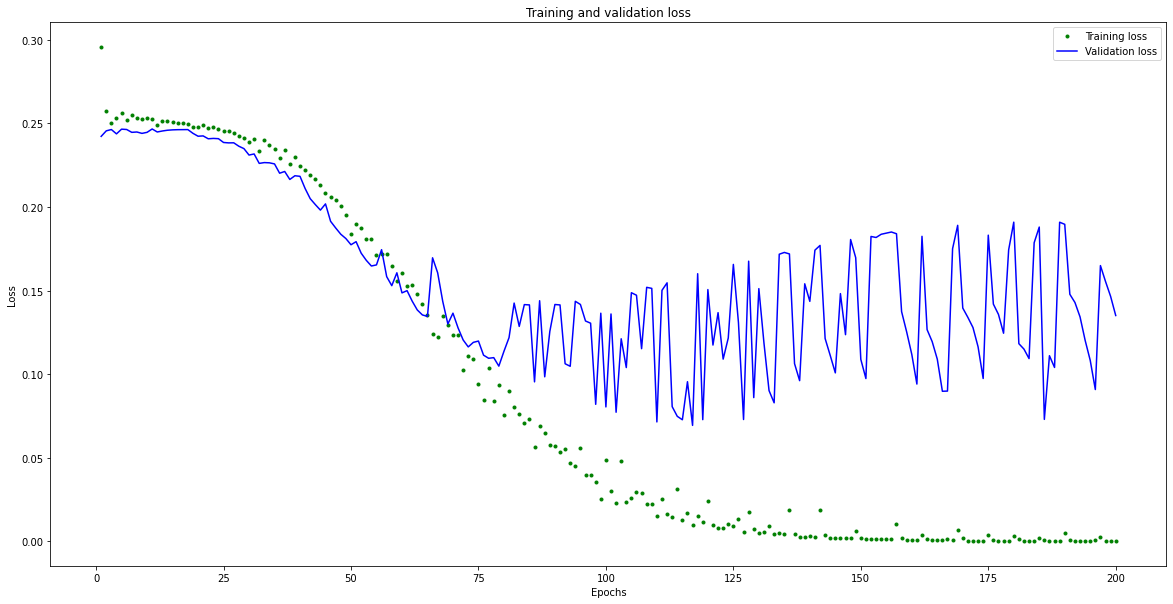

[20.0, 10.0]


In [7]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Run with Test Data
Put our test data into the model and plot the predictions


In [9]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)


predictions =
 [[0.017 0.983]
 [0.162 0.838]
 [0.017 0.983]
 [1.    0.   ]]
actual =
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [10]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

INFO:tensorflow:Assets written to: /tmp/tmpalv9sbr5/assets
Model is 147864 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [11]:
!echo "const unsigned char model[] = {" > model.h
!cat gesture_model.tflite | xxd -i      >> model.h
!echo "};"                              >> model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 911,862 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


# Classifying Data

Now it's time to switch back to the tutorial instructions and run our new model on the Arduino Nano 33 BLE Sense to classify the accelerometer and gyroscope data.
